In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
import geopy.distance
import requests
import json
import geopy.distance
import timeit
from datetime import datetime
from PvGis import PvGis
import numpy as np
import pandas as pd
import json
import matplotlib
import rasterio
from rasterio.plot import show
import rioxarray as rxr
from osgeo import gdal
import csv
import math
import sys
import geopandas as gpd
import networkx as nx
import descartes
from shapely.geometry import Point, Polygon, asShape
import plotly.graph_objects as go
import plotly.express as px

sys.path.append("C:/Users/Jason Collis/Documents/Papers/mapping paper/model/shapefile_to_network/main/convertor")
sys.path.append("C:/Users/Jason Collis/Documents/Papers/mapping paper/model/shapefile_to_network/main/shortest_paths")

from shapefile_to_network.main.convertor.GraphSimplify import GraphSimplify
from shapefile_to_network.main.convertor.GraphConvertor import GraphConvertor
from shapefile_to_network.main.shortest_paths.ShortestPath import ShortestPath
from shapefile_to_network.main.metrics.Centrality import Centrality

from shapely import speedups
speedups.disable()

Convert the created line shapefile into network using GraphConvertor.py

<AxesSubplot:>

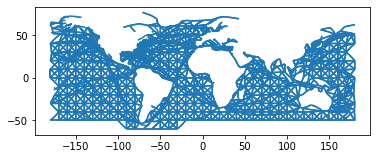

In [2]:
#Create GraphConvertor object by passing the path of input shapefile and the output directory
input_file  =  'Data/shipping/shipping_routes/shipping_routes.shp'
output_dir  =  'Data/shipping/nodes'

graph_convertor_obj = GraphConvertor(input_file, output_dir)

#Call graph_convertor function to convert the input shapefile into road network and save the newly created shapefile 
#into specifed output_dir along with list of nodes and edges in .csv files
network = graph_convertor_obj.graph_convertor()

edges = gpd.read_file(input_file)
nodes = gpd.read_file('Data/shipping/nodes/New Shape/nodes.shp')
edges.plot()

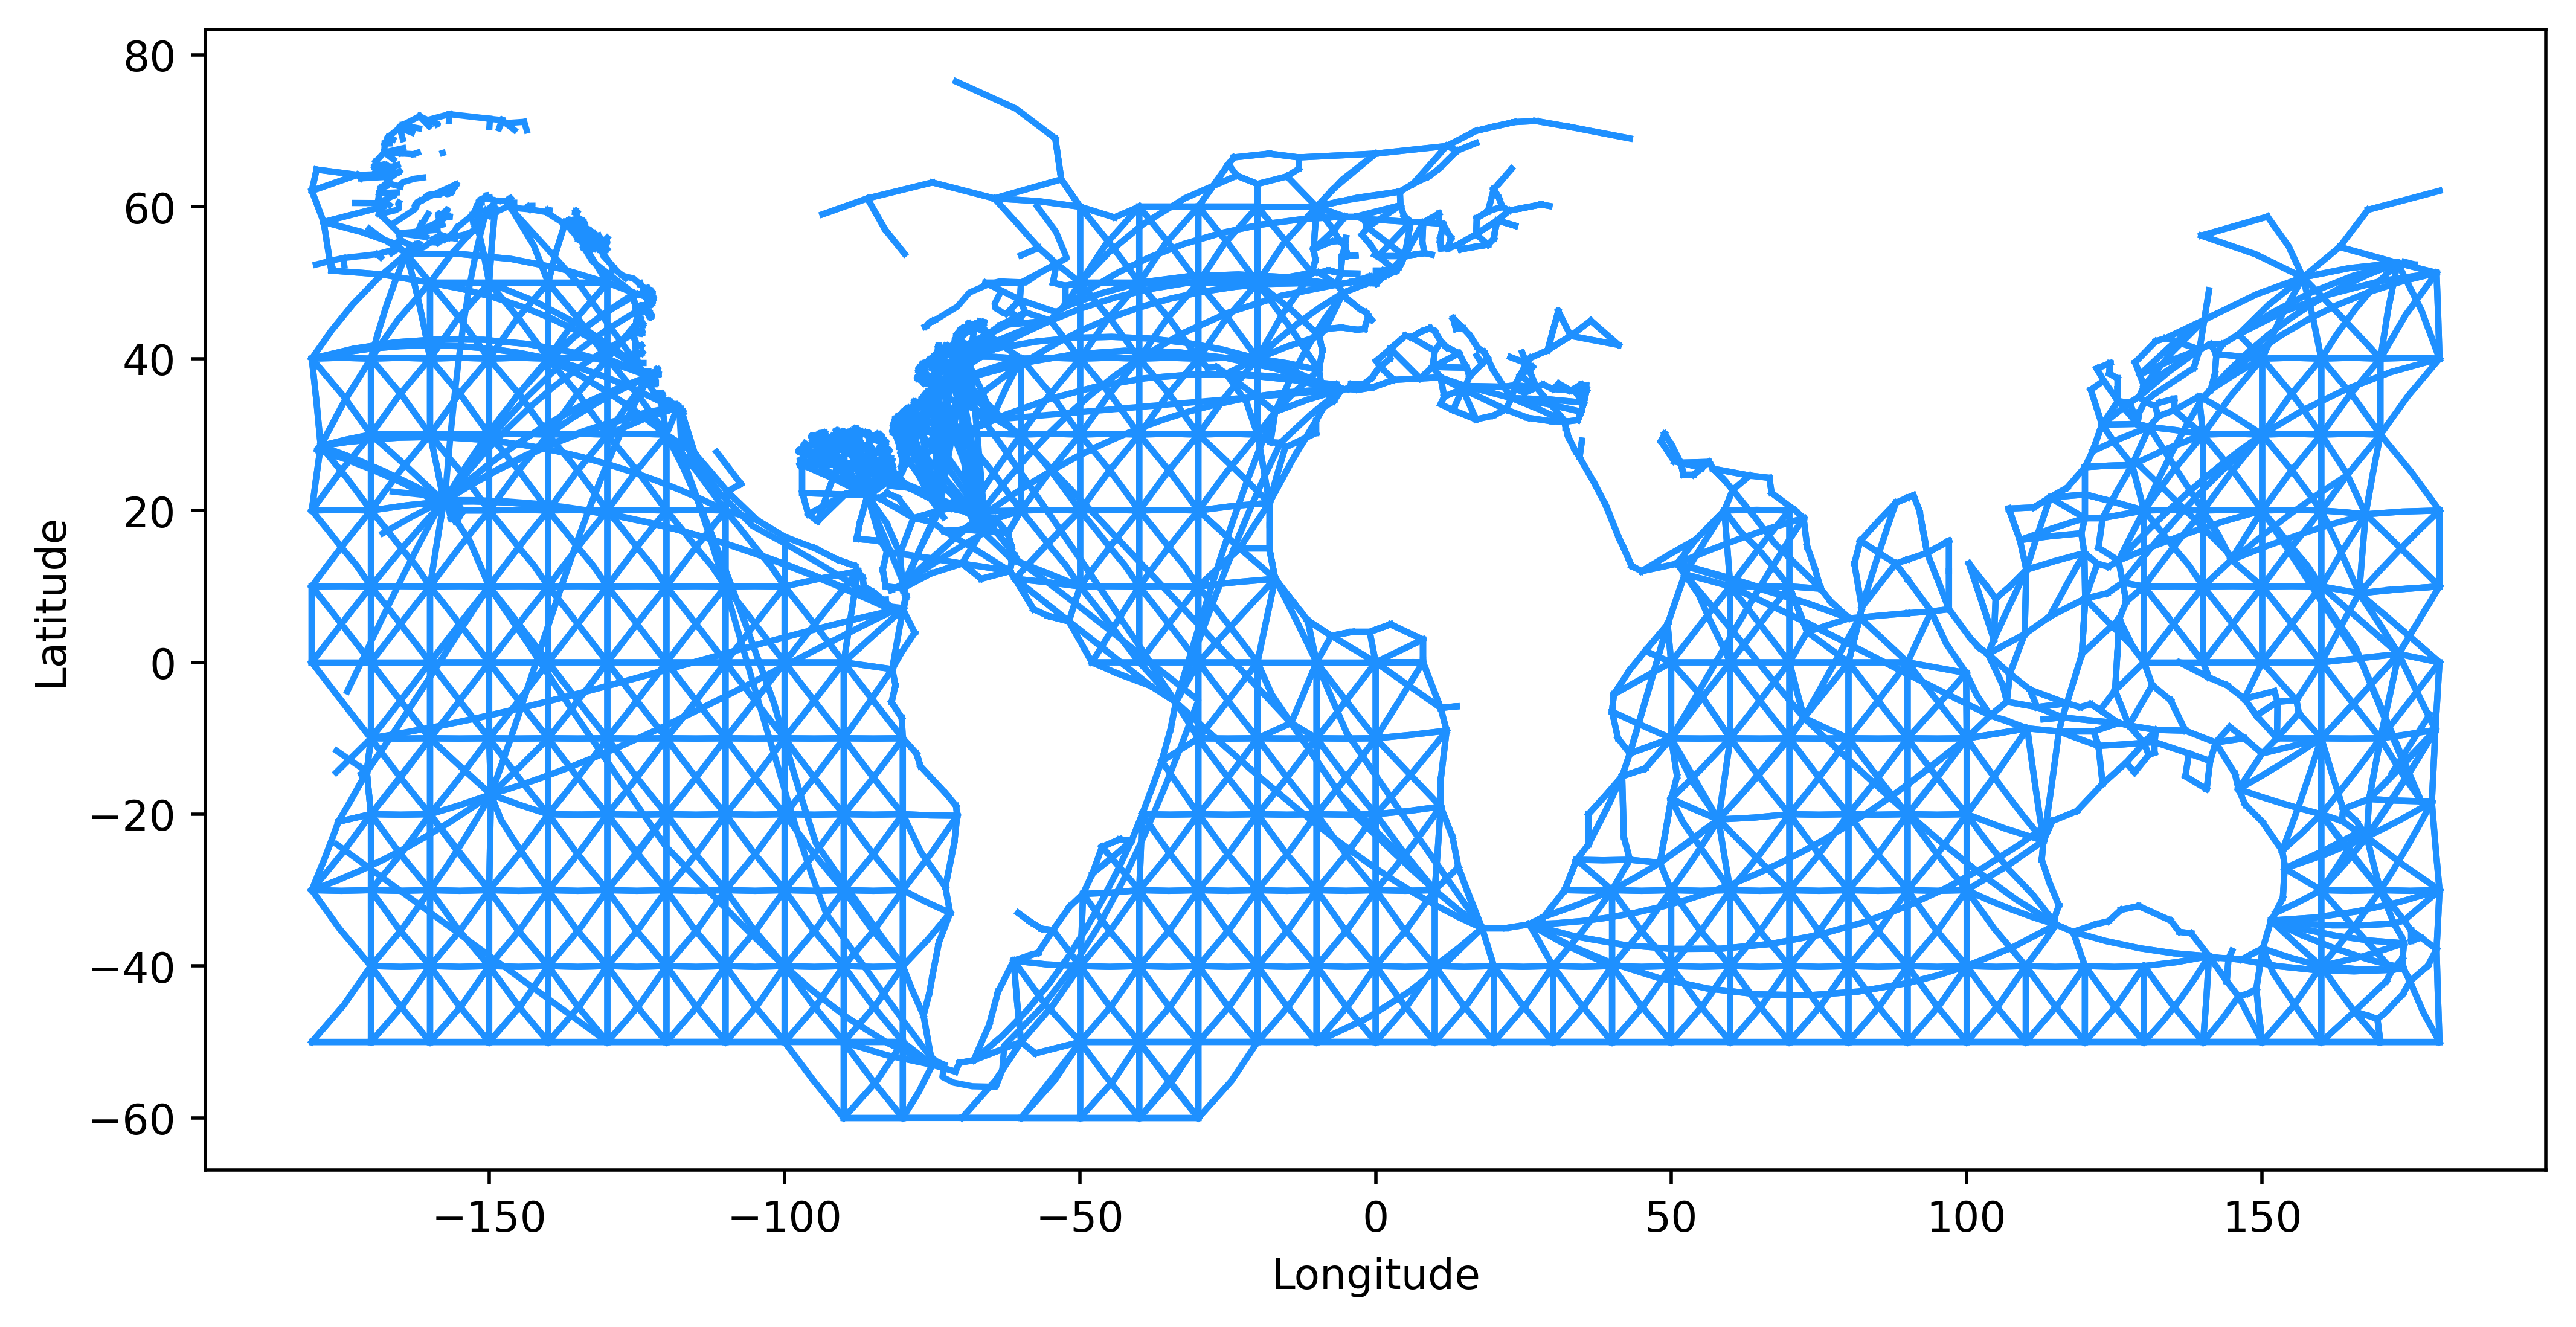

In [3]:
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt

sf = shp.Reader('Data/shipping/shipping_routes/shipping_routes.shp')

fig = plt.figure(figsize=(10, 5), dpi=500)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, color='dodgerblue')
plt.show()
fig.savefig('Results/Graphs/network.png', dpi=fig.dpi)

Find number of shortest paths from origin to destination in new simplified network

In [4]:
def create_port_coordinates(df_ports):
    """Creates a list of the port co-ordinates that can be used to find the nearest port to any point. Requires no
    input."""

    coords = df_ports['coords'].values.tolist()
    coords = [i.strip('()') for i in coords]
    coords = [i.strip("'),'") for i in coords]
    coords = [i.split(', ') for i in coords]

    coords2 = []
    for i in range(len(coords)):
        li = []
        for j in range(2):
            li.append(float(coords[i][j]))
        coords2.append(li)

    return coords2

In [5]:
df_port_index = pd.read_csv('Data/port_index.csv', index_col=0)
df_ports = pd.read_csv('Data/path/ports.csv')

port_coords = create_port_coordinates(df_ports)

start_plant_tuple = (-4.82054142948823, 41.6508390466863)
end_plant_tuple = (6.982777877328413, 50.97030604758192)

#end_plant_tuple = end_plant_tuple[::-1]

# Find the closest port to the end point
distance, index = spatial.KDTree(port_coords).query(start_plant_tuple)  # Needs [long, lat]
start_port_code = df_ports.at[index, 'Unnamed: 0']
print('Start Port Code: ' + str(start_port_code))
start_port_tuple = port_coords[index][::-1]  # Outputs [long, lat]
print('Start Port Tuple: ' + str(start_port_tuple))

# Find the closest port to the end point
distance, index = spatial.KDTree(port_coords).query(end_plant_tuple)  # Needs [long, lat]
end_port_code = df_ports.at[index, 'Unnamed: 0']
print('End Port Code: ' + str(end_port_code))
end_port_tuple = port_coords[index][::-1]  # Outputs [long, lat]
print('End Port Tuple: ' + str(end_port_tuple))

Start Port Code: 2764
Start Port Tuple: [43.433975000000004, -3.81331667164179]
End Port Code: 3915
End Port Tuple: [53.313235000000006, 6.978047335715699]


In [6]:
#Create ShortestPath object by passing all required parameters listed below
g            =  network
alpha        =  0.1
graph_buffer =  300
point_buffer =  1
break_point  =  1 # Upper limit to save computation time

#start timer
start = timeit.default_timer()

shortest_path_obj   =  ShortestPath(g, alpha, graph_buffer, point_buffer, break_point)

#Run alpha_times_shortestpath function to calculate number of paths which are alpha times the shortest path
start_tuple  =  start_port_tuple
end_tuple    =  end_port_tuple

shortest_paths, buffered_graph   =  shortest_path_obj.find_shortest_paths(start_tuple, end_tuple)

shortest_dis = min(shortest_paths.keys())
print('shortest distance: ' + str(shortest_dis))
shortest_path = shortest_paths[shortest_dis]
new_start_coord = shortest_path[0]
print('new start coord: ' + str(new_start_coord))
new_end_coord = shortest_path[len(shortest_path)-1]
print('new end coord: ' + str(new_end_coord))

#stop timer
stop = timeit.default_timer()

print('Time: ', stop - start)


#create dataframe to plot shortest path
df = pd.DataFrame(shortest_path)
utm_crs = {'init': 'epsg:4326'}
#geometry = [Point(xy) for xy in zip(df[0], df[1])]
#geo_df = gpd.GeoDataFrame(df, crs=utm_crs, geometry = geometry)
#geo_df.plot(markersize=20, color='red',marker='o',label = 'Path')
fig = px.line_mapbox(lat=df[0], lon=df[1],
                     mapbox_style="open-street-map", zoom=1)
#fig.show()

C:\Users\Jason\Documents\Papers\mapping paper\model\shapefile_to_network\main\shortest_paths\BufferedGraph.py:32: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = {'init': 'epsg:4326'}
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Jason\Documents\Papers\mapping paper\model\shapefile_to_network\main\shortest_paths\BufferedGraph.py:15: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = to_crs


shortest distance: 1643.7043350041736
new start coord: (43.799999, -3.09999)
new end coord: (53.749969, 6.9)
Time:  0.6845937999999983


In [7]:
fig = go.Figure(data=go.Scattergeo(
    lat = df[0],
    lon = df[1],
    mode = 'lines+markers',
    marker = dict(
        color = 'blue',
        size = 5,
    ),
    line = dict(width = 2, color = 'teal')
))

fig.update_layout(
    geo = dict(
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        projection = dict(
            type = 'natural earth',
            rotation_lon = -100
        ),
    ),
    title='Shortest Path'
)
fig.show()

In [8]:
lat = df[0]
lon = df[1]
coords_ship = []
for i in range(len(lon)):
    coords_ship.append([lat[i],lon[i]])  
    


In [53]:
def add_categorical_legend(folium_map, title, colors, labels):
    if len(colors) != len(labels):
        raise ValueError("colors and labels must have the same length.")

    color_by_label = dict(zip(labels, colors))
    
    legend_categories = ""     
    for label, color in color_by_label.items():
        legend_categories += f"<li><span style='background:{color}'></span>{label}</li>"
        
    legend_html = f"""
    <div id='maplegend' class='maplegend'>
      <div class='legend-title'>{title}</div>
      <div class='legend-scale'>
        <ul class='legend-labels'>
        {legend_categories}
        </ul>
      </div>
    </div>
    """
    script = f"""
        <script type="text/javascript">
        var oneTimeExecution = (function() {{
                    var executed = false;
                    return function() {{
                        if (!executed) {{
                             var checkExist = setInterval(function() {{
                                       if ((document.getElementsByClassName('leaflet-top leaflet-left').length) || (!executed)) {{
                                          document.getElementsByClassName('leaflet-top leaflet-left')[0].style.display = "flex"
                                          document.getElementsByClassName('leaflet-top leaflet-left')[0].style.flexDirection = "column"
                                          document.getElementsByClassName('leaflet-top leaflet-left')[0].innerHTML += `{legend_html}`;
                                          clearInterval(checkExist);
                                          executed = true;
                                       }}
                                    }}, 100);
                        }}
                    }};
                }})();
        oneTimeExecution()
        </script>
      """
   

    css = """

    <style type='text/css'>
      .maplegend {
        z-index:9999;
        float:right;
        background-color: rgba(255, 255, 255, 1);
        border-radius: 5px;
        border: 2px solid #bbb;
        padding: 10px;
        margin-top: 150px;
        margin-left: 100px;
        font-size:12px;
        positon: relative;
      }
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 110%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 100%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 0px solid #ccc;
        }
      .maplegend .legend-source {
        font-size: 100%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    """

    folium_map.get_root().header.add_child(folium.Element(script + css))

    return folium_map

In [54]:
import openrouteservice
from openrouteservice import convert
import folium
from folium.features import DivIcon
import json

client = openrouteservice.Client(key='5b3ce3597851110001cf62487a8aff99152f40b9abb404dbb3a74056')

coords = ((-4.82054142948823, 41.6508390466863),(6.982777877328413, 50.97030604758192))
res = client.directions(coords)
geometry = client.directions(coords)['routes'][0]['geometry']
decoded = convert.decode_polyline(geometry)

distance_txt = "<h4> <b>Distance :&nbsp" + "<strong>"+str(round(res['routes'][0]['summary']['distance']/1000,1))+" Km </strong>" +"</h4></b>"
duration_txt = "<h4> <b>Duration :&nbsp" + "<strong>"+str(round(res['routes'][0]['summary']['duration']/60,1))+" Mins. </strong>" +"</h4></b>"

m = folium.Map(location=[47.10601182628239, 2.776778341167962],zoom_start=5, control_scale=True,tiles="cartodbpositron")
folium.GeoJson(decoded).add_to(m)

coords2 = ((start_plant_tuple),(-3.817048989129514, 43.43038113362553))
res = client.directions(coords2)
geometry = client.directions(coords2)['routes'][0]['geometry']
decoded = convert.decode_polyline(geometry)
folium.GeoJson(decoded, style_function= lambda x :{'color':'darkgreen'}).add_to(m)

coords3 = ((end_plant_tuple),(end_port_tuple[::-1]))
res = client.directions(coords3)
geometry = client.directions(coords3)['routes'][0]['geometry']
decoded = convert.decode_polyline(geometry)
folium.GeoJson(decoded, style_function= lambda x :{'color':'darkgreen'}).add_to(m)

my_PolyLine=folium.PolyLine(locations=coords_ship,weight=3, color='seagreen')
m.add_child(my_PolyLine)

pipe_start = [[start_plant_tuple[1], start_plant_tuple[0]],[43.43038113362553, -3.817048989129514]]
my_PolyLine=folium.PolyLine(locations=pipe_start,weight=3, color='limegreen')
m.add_child(my_PolyLine)

pipe_end = [[end_plant_tuple[1], end_plant_tuple[0]],[end_port_tuple[0], end_port_tuple[1]]]
my_PolyLine=folium.PolyLine(locations=pipe_end,weight=3, color='limegreen')
m.add_child(my_PolyLine)

pipe_full = [[start_plant_tuple[1], start_plant_tuple[0]],[45.759723220002925, 4.837208798185128],[end_plant_tuple[1], end_plant_tuple[0]]]
my_PolyLine=folium.PolyLine(locations=pipe_full,weight=3, color='purple')
m.add_child(my_PolyLine)

ship_start = [[43.43038113362553, -3.817048989129514],[43.8, -3.1]]
my_PolyLine=folium.PolyLine(locations=ship_start, weight=3, color='seagreen')
m.add_child(my_PolyLine)

ship_end = [[end_port_tuple[0], end_port_tuple[1]],[53.75, 6.9]]
my_PolyLine=folium.PolyLine(locations=ship_end, weight=3, color='seagreen')
m.add_child(my_PolyLine)

folium.Marker(
    location=list(coords[0][::-1]),
    popup="Start point",
    icon=folium.Icon(icon='map-marker', color="red"),
).add_to(m)

folium.Marker(
    location=list(coords[1][::-1]),
    popup="End point",
    icon=folium.Icon(icon='map-marker', color="black"),
).add_to(m)

folium.Marker(
    location=[43.43038113362553, -3.817048989129514],
    icon=folium.Icon(icon='exclamation-sign', color="green"),
).add_to(m)

folium.Marker(
    location=[end_port_tuple[0], end_port_tuple[1]],
    icon=folium.Icon(icon='exclamation-sign', color="green"),
).add_to(m)

m = add_categorical_legend(m, 'Transport Options',
                             colors = ['seagreen','dodgerblue','purple'],
                           labels = ['Ship', 'Truck', 'Pipeline'])

folium.map.Marker(
    list(coords[0][::-1]),
    icon=DivIcon(
        icon_size=(300,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 16pt">Example production location</div>',
        )
    ).add_to(m)

folium.map.Marker(
    [43.83038113362553, -6.317048989129514],
    icon=DivIcon(
        icon_size=(250,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 16pt">Start port</div>',
        )
    ).add_to(m)

folium.map.Marker(
    [end_port_tuple[0] + 0.5, end_port_tuple[1] + 0.5],
    icon=DivIcon(
        icon_size=(250,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 16pt">End port</div>',
        )
    ).add_to(m)

folium.map.Marker(
    list(coords[1][::-1]),
    icon=DivIcon(
        icon_size=(250,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 16pt">Desired usage location</div>',
        )
    ).add_to(m)


m.save('Results/Graphs/map.html')
m